## 3.6.4 Housing Prices
In this notebook, I am going to try to predict a house models price based on its attributes.

In [138]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

In [139]:
#lets load the data and take a look
df = pd.read_csv(r'C:\Users\jmfra\OneDrive\Documents\Thinkful Data Science Files\3.6.4 data\housing.csv')
pd.set_option('display.max_columns', 30)
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [140]:
#already I am noticing a bunch of null values so lets take a look at them
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             6831
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          7209
Bathroom          7215
Car               7599
Landsize         10799
BuildingArea     18851
YearBuilt        17126
CouncilArea          3
Lattitude         6986
Longtitude        6986
Regionname           3
Propertycount        3
dtype: int64

In [141]:
df['Price'].isnull().sum()/len(df.index)

0.21740929344366647

In [142]:
#over 20% of the data for the prediction variable is null. That is too large of a portion
#to try and fill in with some determined value so we will ignore those rows
df = df.dropna(subset=['Price'])
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          5650
Bathroom          5654
Car               5945
Landsize          8473
BuildingArea     14847
YearBuilt        13486
CouncilArea          3
Lattitude         5478
Longtitude        5478
Regionname           3
Propertycount        3
dtype: int64

In [143]:
#there is only one null value in distance and postcode so lets take a look at those lines
df[df['Distance'].isnull()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
29483,Fawkner Lot,1/3 Brian St,3,h,616000.0,SP,Brad,6/01/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
#seems one line is void of almost all values so lets toss it
df = df.dropna(subset=['Distance'])
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             0
Postcode             0
Bedroom2          5649
Bathroom          5653
Car               5944
Landsize          8472
BuildingArea     14846
YearBuilt        13485
CouncilArea          2
Lattitude         5477
Longtitude        5477
Regionname           2
Propertycount        2
dtype: int64

In [145]:
#bedroom 2, from the meta data is the number of bedrooms from a different source
#so lets drop it. Also Landsize, Building area, year built, lat and long all have a large
#percentage of the data missing and are either described in other variables or useless
#in context so lets get rid of all of them. Landsize and uilding area would actually be useful
#but getting rid of half the data to use these columns probably isn not the best idea
df = df.drop(['Bedroom2', 'Landsize','BuildingArea','YearBuilt','Lattitude','Longtitude'], axis=1)
df.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bathroom         5653
Car              5944
CouncilArea         2
Regionname          2
Propertycount       2
dtype: int64

In [146]:
df['test'] = df['Rooms'] - df['Bathroom']
df['test'].mean()

1.4514919461315026

In [147]:
#number of bathrooms can be an important identifier of small price changes in a house, but with over 5000 empty rows, it will be 
#hard to find a predictor that fills each value with something reasonable. Also, it does not make sense to fill this with 
#a non whole number by adding the mean to the room number as a guess for how many bathrooms there are since the original
#value is only whole numbers. 
df = df.drop(['Bathroom', 'test'], axis=1)

In [148]:
#number of spots for car is another tricky one. It will definitely affect the price of a property based on a ratio between
#the number of inhabitants and how many spots for cars it has. While we could find some guess based on the area and number
#of rooms, filling in that many data pieces and using a non continous varaible to guess will be a pretty tough process
#so lets just drop it
df = df.drop(['Car'], axis=1)
df.isnull().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
CouncilArea      2
Regionname       2
Propertycount    2
dtype: int64

In [149]:
#when selecting specfic rows it is difficult to use iloc because of the dropped rows from earlier, so lets reindex so each
#row label matches its position
df = df.reset_index(drop=True)

In [150]:
#lets look at the remainder of the missing values
df[df['CouncilArea'].isnull()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,CouncilArea,Regionname,Propertycount
14440,Footscray,2/16 Stafford St,2,u,710000.0,S,Jas,15/07/2017,5.1,3011.0,NaN,NaN,NaN
21054,Camberwell,2/3 Kingsley St,2,h,825000.0,VB,Jellis,11/11/2017,7.7,3124.0,NaN,NaN,NaN


In [151]:
#2 of the inputs have a few points missing which we can probably fill in based on the entries from similarly located properties
df[df['Suburb'] == 'Footscray']

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,CouncilArea,Regionname,Propertycount
3370,Footscray,4/33 Ballarat Rd,3,t,585000.0,S,Nelson,3/09/2016,6.4,3011.0,Maribyrnong City Council,Western Metropolitan,7570.0
3371,Footscray,202/51 Gordon St,1,u,85000.0,PI,Burnham,3/09/2016,6.4,3011.0,Maribyrnong City Council,Western Metropolitan,7570.0
3372,Footscray,4 Adelaide St,4,h,1225000.0,SP,Nelson,3/12/2016,6.4,3011.0,Maribyrnong City Council,Western Metropolitan,7570.0
3373,Footscray,11/44 Everard St,2,u,431000.0,SP,Jas,3/12/2016,6.4,3011.0,Maribyrnong City Council,Western Metropolitan,7570.0
3374,Footscray,9 Lynch St,3,h,1003000.0,S,Naison,3/12/2016,6.4,3011.0,Maribyrnong City Council,Western Metropolitan,7570.0
3375,Footscray,25 Southampton St,3,h,840000.0,S,Sweeney,3/12/2016,6.4,3011.0,Maribyrnong City Council,Western Metropolitan,7570.0
3376,Footscray,37 Stirling St,3,h,1362000.0,S,Village,3/12/2016,6.4,3011.0,Maribyrnong City Council,Western Metropolitan,7570.0
3377,Footscray,58 Wolverhampton St,4,h,977000.0,S,Village,3/12/2016,6.4,3011.0,Maribyrnong City Council,Western Metropolitan,7570.0
3378,Footscray,2/3 Eldridge St,1,u,216000.0,S,Sweeney,4/02/2016,6.4,3011.0,Maribyrnong City Council,Western Metropolitan,7570.0
3379,Footscray,8 Buckingham St,3,h,876000.0,S,Jas,4/03/2017,6.4,3011.0,Maribyrnong City Council,Western Metropolitan,7570.0


In [152]:
#printing the suburb above the exact same way but for the second row with nulls gave us the 
#values you see below
df.iloc[14440, df.columns.get_loc('CouncilArea')] = 'Maribyrnong City Council'
df.iloc[14440, df.columns.get_loc('Regionname')] = 'Western Metropolitan'
df.iloc[14440, df.columns.get_loc('Propertycount')] = 7570.0
df.iloc[21054, df.columns.get_loc('CouncilArea')] = 'Boroondara City Council'
df.iloc[21054, df.columns.get_loc('Regionname')] = 'Southern Metropolitan'
df.iloc[21054, df.columns.get_loc('Propertycount')] = 8920.0

In [153]:
df.isnull().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
CouncilArea      0
Regionname       0
Propertycount    0
dtype: int64

In [154]:
#now that there are no nulls lets look at the categorical variables
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,CouncilArea,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,Yarra City Council,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,Yarra City Council,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,Yarra City Council,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,Yarra City Council,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,Yarra City Council,Northern Metropolitan,4019.0


In [155]:
df['Rooms'].groupby(df['Suburb']).count().describe()

count    341.000000
mean      72.105572
std       87.746765
min        1.000000
25%       12.000000
50%       39.000000
75%      102.000000
max      673.000000
Name: Rooms, dtype: float64

In [156]:
#looks like a fine variable to make dummies out of. 
#address is a useless category
df = df.drop('Address', axis=1)

In [157]:
print(df['Suburb'].groupby(df['Type']).count())
df['Suburb'].groupby(df['Method']).count()

Type
h    16567
t     2589
u     5432
Name: Suburb, dtype: int64


Method
PI     2892
S     15947
SA      173
SP     3223
VB     2353
Name: Suburb, dtype: int64

In [158]:
#also good varaibles for dummies
df['Rooms'].groupby(df['SellerG']).count().describe()

count     340.000000
mean       72.317647
std       277.318522
min         1.000000
25%         1.000000
50%         4.000000
75%        22.000000
max      2509.000000
Name: Rooms, dtype: float64

In [159]:
#since the sellers are not grouped by company, this is heavily skewed and will be hard to work with because it creates a column 
#for 20000 entries with only 1 actual entry for over a quarter of the 340 values. This will overfit to this set. 
#also postcode is a categorical variable that descirbes the neigherhood that you are in which is already another variable
#so we can delete it as well
df = df.drop(['SellerG', 'Postcode'], axis=1)

In [160]:
#date is a very good category to use, however the varaible is too difficult to work with to actually use. scikit learn does not 
#inherintly understand a date so you would have to either assign a continous variable to a date with 3 levels or make them 
#categories. Also not all dates are described in this set, only dates when homes where actually sold so the model wouldnt 
#accurately represent the market over time, it would only be able to model the average of homes sold on a specific day which
#is very easily skewed. For example if the market improves linearly over time, but on a random day 2 years into the study there 
#are 5 houses sold in the bottom 10% of price, the model would think all houses sold on this date are worth a lot less than they
#should be. Since it is so difficult to work with we can drop it
df['Rooms'].groupby(df['Date']).count().describe()
df = df.drop(['Date'], axis=1)

count     73.000000
mean     336.821918
std      183.283883
min        2.000000
25%      239.000000
50%      336.000000
75%      449.000000
max      879.000000
Name: Rooms, dtype: float64

In [161]:
df['Suburb'].groupby(df['CouncilArea']).count().describe()

count      33.000000
mean      745.090909
std       632.716730
min         5.000000
25%       209.000000
50%       730.000000
75%      1167.000000
max      2322.000000
Name: Suburb, dtype: float64

In [162]:
df['Suburb'].groupby(df['Regionname']).count()

Regionname
Eastern Metropolitan          2889
Eastern Victoria               146
Northern Metropolitan         7075
Northern Victoria              136
South-Eastern Metropolitan    1183
Southern Metropolitan         7817
Western Metropolitan          5257
Western Victoria                85
Name: Suburb, dtype: int64

In [163]:
df.head()

,Suburb,Rooms,Type,Price,Method,Date,Distance,CouncilArea,Regionname,Propertycount
0,Abbotsford,2,h,1480000.0,S,3/12/2016,2.5,Yarra City Council,Northern Metropolitan,4019.0
1,Abbotsford,2,h,1035000.0,S,4/02/2016,2.5,Yarra City Council,Northern Metropolitan,4019.0
2,Abbotsford,3,h,1465000.0,SP,4/03/2017,2.5,Yarra City Council,Northern Metropolitan,4019.0
3,Abbotsford,3,h,850000.0,PI,4/03/2017,2.5,Yarra City Council,Northern Metropolitan,4019.0
4,Abbotsford,4,h,1600000.0,VB,4/06/2016,2.5,Yarra City Council,Northern Metropolitan,4019.0


In [164]:
#now that we have confirmed the categorical variables look ok, lets actually create dummies and drop the original
df = pd.concat([df, pd.get_dummies(df['Suburb'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['Type'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['Method'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['CouncilArea'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['Regionname'])], axis=1)
df = df.drop(['Suburb', 'Type', 'Method', 'CouncilArea', 'Regionname'], axis=1)

In [165]:
df.head()

,Rooms,Price,Distance,Propertycount,Abbotsford,Aberfeldie,Airport West,Albanvale,Albert Park,Albion,Alphington,Altona,Altona Meadows,Altona North,Ardeer,...,Port Phillip City Council,Stonnington City Council,Whitehorse City Council,Whittlesea City Council,Wyndham City Council,Yarra City Council,Yarra Ranges Shire Council,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria
0,2,1480000.0,2.5,4019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1035000.0,2.5,4019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,1465000.0,2.5,4019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,850000.0,2.5,4019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,1600000.0,2.5,4019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [166]:
#lets take one last look at the continous varaibles to look at outliers
df.iloc[:,0:5].describe()

,Rooms,Price,Distance,Propertycount,Abbotsford
count,24588.000000,2.458800e+04,24588.000000,24588.000000,24588.000000
mean,2.980356,1.048359e+06,11.141362,7559.554173,0.003986
std,0.959791,6.415228e+05,6.704955,4498.519359,0.063008
min,1.000000,8.500000e+04,0.000000,83.000000,0.000000
25%,2.000000,6.350000e+05,6.400000,4294.000000,0.000000
50%,3.000000,8.700000e+05,10.400000,6567.000000,0.000000
75%,4.000000,1.292000e+06,13.900000,10412.000000,0.000000
max,16.000000,1.120000e+07,48.100000,21650.000000,1.000000


C:\Users\jmfra\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x2b088d8cf28>],
 'caps': [<matplotlib.lines.Line2D at 0x2b088d979e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b088d650f0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2b088d65780>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2b088d94978>,
  <matplotlib.lines.Line2D at 0x2b088d94b00>]}

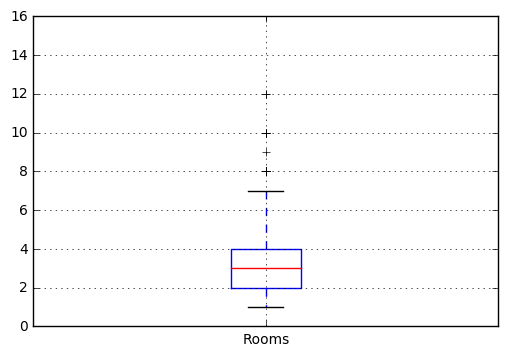

In [167]:
df.boxplot(column='Rooms')

C:\Users\jmfra\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  from ipykernel import kernelapp as app


(2270000, 2300000)

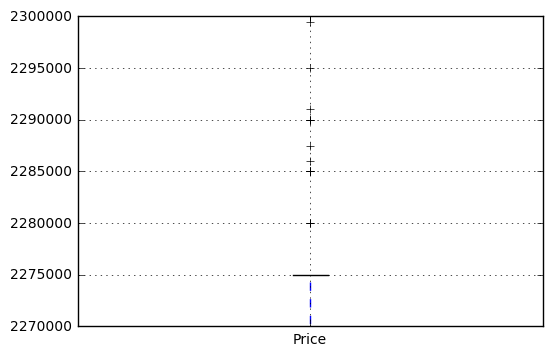

In [168]:
#getting rid of outliers in room. we are creating a new dataframe here so that we are not cutting too much data
#by looking at outliers after some data has been removed. after guess and checking the boxplot below, i found the outlier split 
#for price at 2275000
df_drop = df[df['Rooms'] <= 7]
a = df.boxplot(column='Price')
plt.ylim(2270000, 2300000)

C:\Users\jmfra\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  from ipykernel import kernelapp as app


(24, 26)

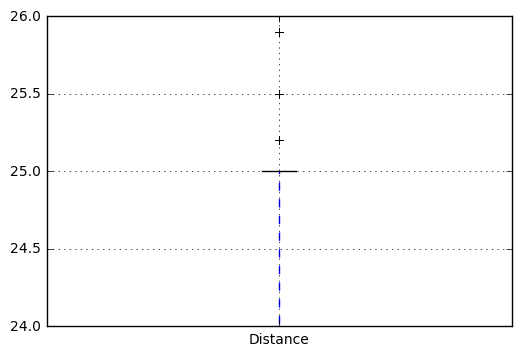

In [170]:
df_drop = df_drop[df_drop['Price'] <= 2275000]
a = df.boxplot(column='Distance')
plt.ylim(24, 26)

In [171]:
df_drop = df_drop[df_drop['Distance'] <= 25]

In [172]:
df_drop.head()

,Rooms,Price,Distance,Propertycount,Abbotsford,Aberfeldie,Airport West,Albanvale,Albert Park,Albion,Alphington,Altona,Altona Meadows,Altona North,Ardeer,...,Port Phillip City Council,Stonnington City Council,Whitehorse City Council,Whittlesea City Council,Wyndham City Council,Yarra City Council,Yarra Ranges Shire Council,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria
0,2,1480000.0,2.5,4019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1035000.0,2.5,4019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,1465000.0,2.5,4019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,850000.0,2.5,4019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,1600000.0,2.5,4019.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [174]:
#lets select our variables and run a few types of linear regression to see how good this model can get
X = df_drop.drop('Price',axis=1)
y = df_drop['Price'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .20, random_state= 0)

In [175]:
LR = LinearRegression(normalize=True)
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)
LR.score(X_train,y_train)

0.71863545694534503

In [176]:
LR.score(X_test,y_test)

0.70042270296601428

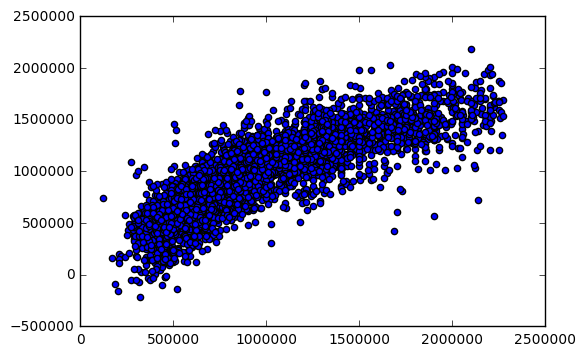

In [177]:
#while very consistent, .71~ is not that great of a score. lets take a look at the predictedd scores
plt.scatter(y_test, y_pred)

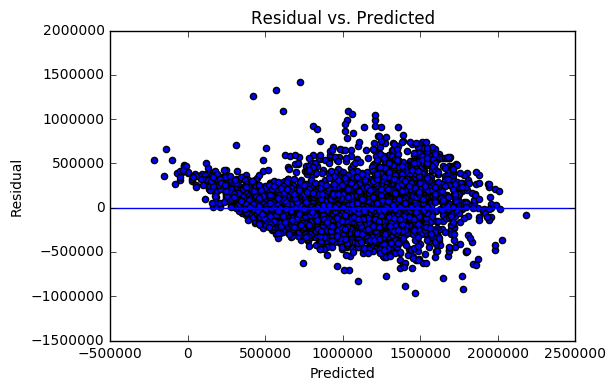

In [178]:
predicted = y_pred
actual = y_test
residual = actual - predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [179]:
#lets use both types of linear corrections to see if we can get a better prediction
alpha = [.001,.01,1,10,100,1000]
for x in alpha:
    lass = linear_model.Lasso(alpha=x)
    lassfit = lass.fit(X_train, y_train)
    print(x)
    print(lass.score(X_train, y_train))
    print(lass.score(X_test, y_test))

C:\Users\jmfra\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.001
0.71963938828
0.700796899649
0.01
0.719639388134
0.700796988186
1
0.719637506857
0.700869016266
10
0.719494414465
0.70138146479
100
0.715226956115
0.699199487278
1000
0.668417386833
0.6530979737


In [180]:
alpha = [.001,.01,1,10,100,1000]
for x in alpha:
    linear_model.Ridge
    ridge = linear_model.Ridge(alpha=x)
    ridgefit = ridge.fit(X_train, y_train)
    print(x)
    print(ridge.score(X_train, y_train))
    print(ridge.score(X_test, y_test))

0.001
0.719639388135
0.700797732867
0.01
0.719639373755
0.700805318071
1
0.71956340581
0.701341144057
10
0.717747427881
0.701025164999
100
0.698518463713
0.682520400426
1000
0.640543277136
0.6224798494


Unfortunately, the model did not improve from the .71. With the original data set, this is likely the best we can do without getting rid of a huge portion of the data and over fitting our model extensively. Using date, seller, landsize, buildingsize, and yearbuilt to model this data would be very useful, however each data type had an obvious short fall in its collection causing it to be either unusable or too difficult to work with. 
Date had a random selection of dates, causing it to be a categorical variable instead of a potential continuous one which is an issue becasue of the amount of features with only 1 entry. 
Seller is not grouped in any way causing the same issue as date becasue over 50% of the data had 4 or less entries which does not provide any useful information for linear regression.
Landsize, BuildingSize, and YearBuilty had over 10000 missing entries which is too high of a number for us to just delete rows without it or to guess what values should go there. All three of these we would expect to see a direct relationship with cost as well for obvious reasons. The greater the land or yard size, the more it costs. The greater the building, the more it will cost. The year built will scale inversily if you change it to age from a certain date because it will have more upkeep risk.